In [12]:
%matplotlib inline
import numpy as np
from skyfield.api import load, Topos
from scipy.optimize import newton
from matplotlib import pyplot as plt
planets = load('de423.bsp')

In [87]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023):
        self.size = size
        self.mjd = mjd
        self.lambda_N = 0
        self.a = self.gen_a()
        self.e = self.gen_e()
        self.i = self.gen_i()
        self.amp = self.gen_amp()
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg(self.phi, self.M, self.node, self.lambda_N)
        self.H = self.gen_H()
        cut = self.e > 0
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]
        self.X, self.Y, self.Z = zip(*map(self.kep_to_xyz, self.a, self.e, self.i, self.arg, self.node, self.M))
        self.xyz_to_equa(self.X, self.Y, self.Z)
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self):
        return np.random.normal(loc=0.175, scale=0.06, size = self.size)
        
    def gen_i(self):
        return np.arcsin(np.random.rayleigh(scale = 12 * np.pi/180., size = self.size))
        
    def gen_amp(self):
        return np.random.triangular(0, 5, 10, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size)) 
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size) % (2*np.pi)
        
    def gen_arg(self, phi, M, node, lambda_N):
        return (0.5*phi - 1.5*M - node + lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the radius
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        X = np.array(X0) - x_earth
        Y = np.array(Y0) * np.cos(epsilon) + np.array(Z0) * np.sin(epsilon)  - y_earth
        Z = np.array(Y0) * np.sin(epsilon) - np.array(Z0) * np.cos(epsilon) - z_earth
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)

In [88]:
p = plutino(size = 2000)

(array([174., 202., 209., 201., 189., 184., 214., 223., 187., 212.]),
 array([39.25004037, 39.29002501, 39.33000965, 39.36999429, 39.40997893,
        39.44996357, 39.48994821, 39.52993285, 39.56991749, 39.60990213,
        39.64988677]),
 <a list of 10 Patch objects>)

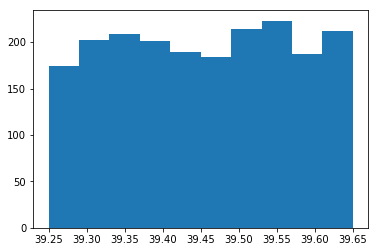

In [89]:
plt.hist(p.a)

(array([ 24.,  84., 233., 395., 510., 398., 234.,  86.,  26.,   5.]),
 array([0.00062145, 0.03926587, 0.07791029, 0.11655471, 0.15519913,
        0.19384355, 0.23248797, 0.27113239, 0.30977681, 0.34842123,
        0.38706565]),
 <a list of 10 Patch objects>)

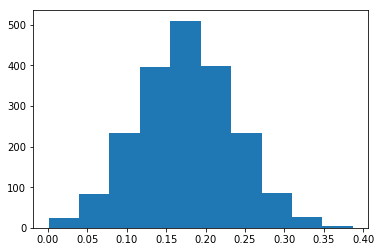

In [90]:
plt.hist(p.e)

(array([235., 489., 612., 353., 187.,  75.,  24.,  13.,   3.,   4.]),
 array([ 0.39025476,  6.13958837, 11.88892198, 17.63825558, 23.38758919,
        29.13692279, 34.8862564 , 40.63559001, 46.38492361, 52.13425722,
        57.88359083]),
 <a list of 10 Patch objects>)

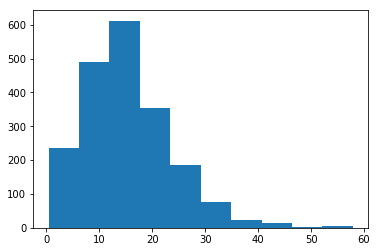

In [91]:
plt.hist(p.i*180/np.pi)

(array([2.000e+00, 1.000e+00, 3.000e+00, 8.000e+00, 1.700e+01, 3.900e+01,
        1.220e+02, 2.050e+02, 4.950e+02, 1.103e+03]),
 array([6.0261908 , 6.42355927, 6.82092774, 7.2182962 , 7.61566467,
        8.01303313, 8.4104016 , 8.80777006, 9.20513853, 9.60250699,
        9.99987546]),
 <a list of 10 Patch objects>)

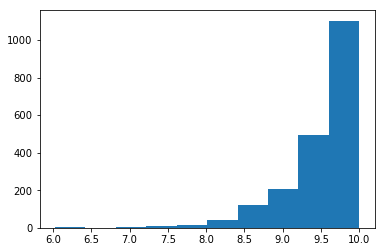

In [92]:
plt.hist(p.H)

(array([191., 175., 216., 213., 217., 218., 188., 186., 179., 212.]),
 array([ 0.01256685,  1.26732713,  2.52208741,  3.7768477 ,  5.03160798,
         6.28636826,  7.54112854,  8.79588883, 10.05064911, 11.30540939,
        12.56016967]),
 <a list of 10 Patch objects>)

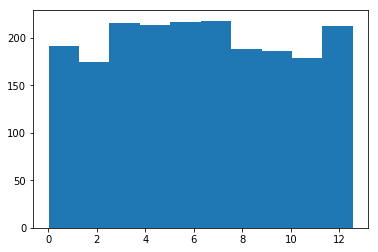

In [93]:
plt.hist(p.M)

(array([201., 175., 188., 208., 193., 219., 193., 202., 203., 213.]),
 array([3.27286254e-03, 6.30863596e-01, 1.25845433e+00, 1.88604506e+00,
        2.51363580e+00, 3.14122653e+00, 3.76881726e+00, 4.39640800e+00,
        5.02399873e+00, 5.65158946e+00, 6.27918020e+00]),
 <a list of 10 Patch objects>)

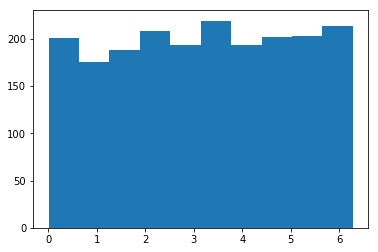

In [94]:
plt.hist(p.arg)

(array([188., 189., 211., 196., 197., 181., 209., 196., 216., 212.]),
 array([9.00236687e-04, 6.29000059e-01, 1.25709988e+00, 1.88519970e+00,
        2.51329952e+00, 3.14139935e+00, 3.76949917e+00, 4.39759899e+00,
        5.02569881e+00, 5.65379863e+00, 6.28189845e+00]),
 <a list of 10 Patch objects>)

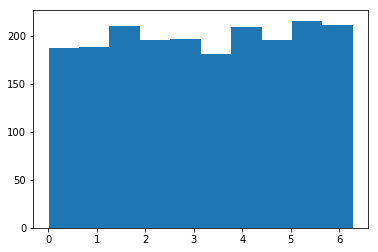

In [95]:
plt.hist(p.node)

(array([ 39., 110., 224., 273., 331., 338., 278., 217., 138.,  47.]),
 array([ 0.18352363,  1.41169804,  2.63987245,  3.86804686,  5.09622127,
         6.32439568,  7.55257009,  8.7807445 , 10.00891891, 11.23709332,
        12.46526773]),
 <a list of 10 Patch objects>)

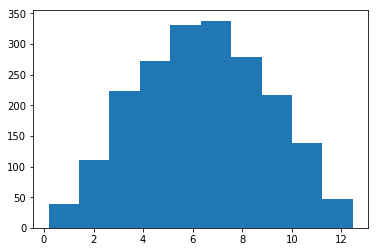

In [96]:
plt.hist(p.arg+p.node)

In [97]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [98]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

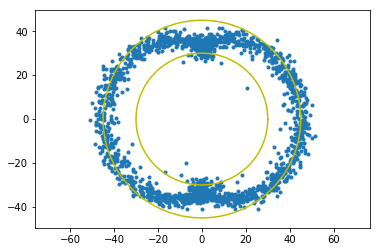

In [99]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')

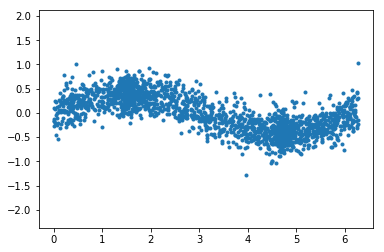

In [100]:
plt.axis('equal')
plt.scatter(p.ra,p.dec, marker = '.')